In [2]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '/mnt/d/GitHub/pypsa_utilities/eskom data/')

import data_utilities as du
import plotting_utilities as pu
import financial_utilities as fu

In [60]:
eskom_data=du.eskom_data('../data/ESK2546.csv')

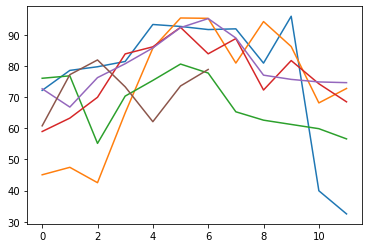

In [50]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 


for y in [2017,2018,2019,2020,2021,2022]:
    data=df.loc['Lethabo','EAF %']
    plt.plot(data[data.index.year==y].values)



In [ ]:
df[df.type=='coal'].groupby('Date').sum()['capacity'].divide(df[df.type=='coal'].groupby('Date').sum()['MW']).plot()

Text(0, 0.5, 'Coal fleet EAF')

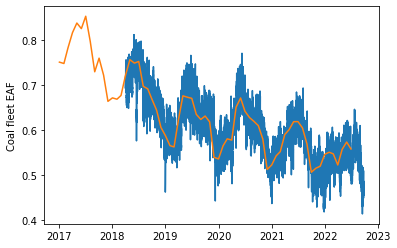

In [63]:
plt.plot(eskom_data['coal_eaf'])
plt.plot(df[df.type=='coal'].groupby('Date').sum()['capacity'].divide(df[df.type=='coal'].groupby('Date').sum()['MW']))
plt.ylabel('Coal fleet EAF')

AttributeError: 'list' object has no attribute 'plot'

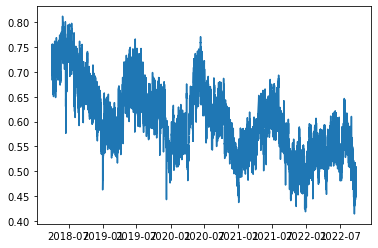

In [61]:
plt.plot(eskom_data['coal_eaf']).plot()

In [22]:
n = pypsa.Network("../networks/pre_ambitions_9-supply_redz_lcopt_LC.nc")


INFO:pypsa.io:Imported network pre_ambitions_9-supply_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [26]:
n.lines

,bus0,bus1,length,num_parallel,s_nom_min,s_nom_extendable,type,capital_cost,s_max_pu,x,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
0,EASTERN CAPE,FREE STATE,494.565353,0.500000,849.051306,True,Al/St 240/40 4-bundle 380.0,308193.824887,0.7,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EASTERN CAPE,KZN,702.781934,0.500000,849.051306,True,Al/St 240/40 4-bundle 380.0,437946.271020,0.7,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EASTERN CAPE,NORTHERN CAPE,709.406767,2.326870,3951.263695,True,Al/St 240/40 4-bundle 380.0,442074.608057,0.7,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EASTERN CAPE,WESTERN CAPE,693.122519,0.500000,849.051306,True,Al/St 240/40 4-bundle 380.0,431926.900338,0.7,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FREE STATE,GAUTENG,381.671114,4.712396,8002.132162,True,Al/St 240/40 4-bundle 380.0,237842.541513,0.7,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,FREE STATE,KZN,473.546735,0.500000,849.051306,True,Al/St 240/40 4-bundle 380.0,295095.842100,0.7,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,FREE STATE,MPUMALANGA,569.987267,NaN,NaN,True,Al/St 240/40 4-bundle 380.0,355193.817901,0.7,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,FREE STATE,NORTH WEST,366.030831,2.836963,4817.454783,True,Al/St 240/40 4-bundle 380.0,228096.127119,0.7,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,FREE STATE,NORTHERN CAPE,674.168985,9.509626,16148.320813,True,Al/St 240/40 4-bundle 380.0,420115.797956,0.7,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

carrier
CCGT             1.415105e+04
OCGT             6.201964e+03
coal             3.304200e+04
load_shedding    2.700000e+07
nuclear          1.860000e+03
onwind           7.243488e+04
solar            4.350048e+04
Name: p_nom_opt, dtype: float64

<AxesSubplot:xlabel='timestep'>

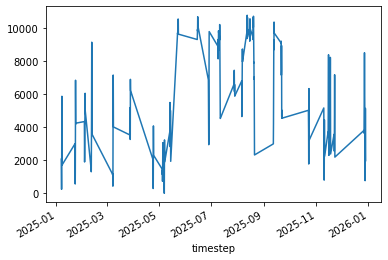

In [107]:
n.generators_t.p['EAST LONDON onwind_2025'].loc[2025].plot()

<AxesSubplot:xlabel='Generator'>

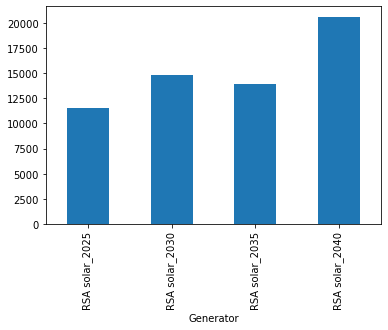

In [96]:
n.generators.p_nom_opt[n.generators.carrier=='solar'].plot.bar()

In [79]:
n=pypsa.Network("../networks/solved_original_27-supply_redz_lcopt_LC.nc")

FileNotFoundError: [Errno 2] No such file or directory: b'/mnt/d/GitHub/pypsa-za/networks/solved_original_27-supply_redz_lcopt_LC.nc'

<AxesSubplot:xlabel='Generator'>

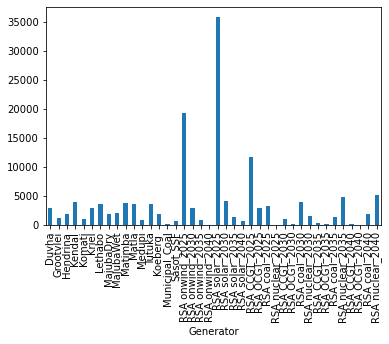

In [74]:
n.generators.p_nom_opt.drop('RSA load_shedding').plot.bar()

In [76]:
n.snapshots.levels[0]

Int64Index([2025, 2030, 2035, 2040], dtype='int64', name='period')

In [13]:
n.generators.loc['RSA solar_2025',:]

carrier                          solar
p_nom                              0.0
build_year                        2025
y                                  NaN
x                                  NaN
efficiency                         1.0
marginal_cost                 0.020499
capital_cost            2728290.697247
ramp_limit_up                      NaN
lifetime                          25.0
bus                                RSA
p_nom_extendable                  True
p_nom_max                867829.274064
control                             PQ
p_nom_opt                     0.000703
type                                  
p_nom_min                          0.0
p_min_pu                           0.0
p_max_pu                           1.0
p_set                              0.0
q_set                              0.0
sign                               1.0
committable                      False
start_up_cost                      0.0
shut_down_cost                     0.0
min_up_time              

In [11]:
n.generators.loc['RSA CCGT_2025',:]

carrier                           CCGT
p_nom                              0.0
build_year                        2025
y                                  NaN
x                                  NaN
efficiency                        0.49
marginal_cost              1124.050157
capital_cost            3835104.858603
ramp_limit_up                      NaN
lifetime                          30.0
bus                                RSA
p_nom_extendable                  True
p_nom_max                          inf
control                             PQ
p_nom_opt                 21055.502587
type                                  
p_nom_min                          0.0
p_min_pu                           0.0
p_max_pu                           1.0
p_set                              0.0
q_set                              0.0
sign                               1.0
committable                      False
start_up_cost                      0.0
shut_down_cost                     0.0
min_up_time              

In [13]:
n.get_active_assets('Generator',2030)

Generator
Duvha                 True
Grootvlei            False
Hendrina             False
Kendal                True
Komati               False
Kriel                False
Lethabo               True
MajubaDry             True
MajubaWet             True
Matimba               True
Matla                 True
Medupi                True
Tutuka                True
Koeberg               True
Municipal_Coal        True
Sasol_SSF             True
RSA onwind_2025       True
RSA onwind_2030       True
RSA solar_2025        True
RSA solar_2030        True
RSA CCGT_2025         True
RSA OCGT_2025         True
RSA coal_2025         True
RSA nuclear_2025      True
RSA CCGT_2030         True
RSA OCGT_2030         True
RSA coal_2030         True
RSA nuclear_2030      True
RSA load_shedding     True
dtype: bool

In [11]:
n.generators

,carrier,p_nom,build_year,y,x,efficiency,marginal_cost,capital_cost,ramp_limit_up,lifetime,...,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Duvha,coal,2900.0,2025,-25.95954,29.34094,0.326264,187.210393,5.940000e+05,0.068276,9.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Grootvlei,coal,1080.0,2025,-26.76955,28.49951,0.285488,335.690980,5.940000e+05,0.050000,3.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Hendrina,coal,1900.0,2025,-26.03138,29.60138,0.296760,263.236840,5.940000e+05,0.034737,1.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Kendal,coal,3840.0,2025,-26.08805,28.96888,0.306305,275.616770,5.940000e+05,0.028125,18.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Komati,coal,900.0,2025,-26.09078,29.47446,0.260323,300.401081,5.940000e+05,0.033333,3.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Kriel,coal,2880.0,2025,-26.25404,29.18008,0.320199,266.129574,5.940000e+05,0.075000,4.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Lethabo,coal,3540.0,2025,-26.74027,27.97500,0.328018,179.930346,5.940000e+05,0.100000,15.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaDry,coal,1830.0,2025,-27.09555,29.77055,0.306305,313.224713,5.940000e+05,0.055738,23.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaWet,coal,2010.0,2025,-27.09555,29.77055,0.327154,313.403729,5.940000e+05,0.056716,26.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
